In [1]:
# ---------------------- IMPORTS ----------------------
import os
from os.path import basename
if basename(os.getcwd()) == 'util':
    os.chdir("../")
import config.model
if basename(os.getcwd()) == 'experiment-framework':
    os.chdir("util/")
import numpy  as np
import torch
import pickle
import copy
from collections import OrderedDict
import matplotlib
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
import torch.utils.data as utils
import torch.nn.functional as F

from activation_plot_code import plot_combination_acts
from activation_plot_code import plot_act_matrix
from activation_plot_code import plot_accuracy_table
from activation_plot_code import plot_ablation_accuracies
from activation_plot_code import get_acts_matrix
from activation_plot_code import get_accuracy_ablation
from activation_plot_code import get_med_and_std
from activation_plot_code import make_first_upper
from activation_plot_code import get_selectivity_dicts2


## Use notebook after running activations.py in main directory

<br>

# Enter Info

- <b>dataset_name</b>: The name of the dataset

- <b>layer</b>: either "", "_layer1", "_layer3". Specifies which layer the activation heat map shows

- <b>model_name</b>: either "simple_cnn", "resnet", "resnet_no_pool", "resnet_pretrained", "resnet_pretrained_embeddings", or "resnet_early_branching"

- <b>state_dict_type</b>: either  "_color_only", "_shape_only", "_location_only", or "". Used for specifying whether the network is trained only on a single task. use empty list if not trained on single task.

- <b>show_violin_plot_median/mean/extrema</b>: for violin plots

- <b>individual_neuron_plots_start/end_index</b>: index range of neurons shown in individual neuron activation/variance plots

- <b>num_clusters</b>: how many clusters to use in activation matrix plot

- <b>save</b>: for saving generated plots

In [2]:
# ----------------- ENTER INFO -----------------

#dataset names to choose from: 
#    "left_out_varied_location_mnist", "left_out_colored_mnist, left_out_many_scale_mnist", "left_out_colored_location_mnist"
dataset_name = "left_out_colored_mnist"

#layer name to choose from: 
#    "", "_layer1", "_layer3"
layer = "" 

#model names to choose from:
#    "simple_cnn", "resnet", "resnet_no_pool", "resnet_pretrained",
#    "resnet_pretrained_embeddings", "resnet_early_branching"
model_name = "resnet"

#Select type of state_dict
#    "_color_only", "_shape_only", "_location_only", "" 
state_dict_type = ""

#For plots. Show median/mean/extrema
show_violin_plot_median = True
show_violin_plot_mean = False
show_violin_plot_extrema = True

#Which of the 512 units are displayed in the individual and
#    std/mean/divide plots
individual_neuron_plots_start_index = 9
individual_neuron_plots_end_index = 11

#for activation plots. How many clusters
num_clusters = 20


#can change keep_pct to get activation plots for different % seen combos

#for left_out_colored_mnist, choices are:
#    .1,.2,.3,.4,.5,.6,.7,.8,.9
if dataset_name == "left_out_colored_mnist":
    keep_pct = 0.9

#for left_out_varied_location_mnist and left_out_many_scale_mnist, choices are:
#    0.1111111111111111,0.2222222222222222,0.3333333333333333,
#    0.4444444444444444,0.5555555555555556,0.6666666666666666,
#    0.7777777777777778,0.8888888888888888
elif dataset_name in ["left_out_varied_location_mnist","left_out_many_scale_mnist",'left_out_colored_location_mnist']:
    keep_pct = 0.8888888888888888
else:
    keep_pct = 0.8888888888888888
    

keep_pct_string = str(int(100*keep_pct))

    
#Choose True if want to save plots to pdf
save = False


plot_path = act_matrix_path = "../analysis/analysis_plots/" + model_name + "_plots/" + dataset_name + state_dict_type
if dataset_name == "left_out_colored_location_mnist":
    num_tasks = 3
else:
    num_tasks = 2
    
if model_name == "resnet_early_branching" and layer != "_layer1":
    branching = True
else:
    branching = False



<br>

# Load Data for activation heatmap plots

In [3]:
# ----------------- LOAD DATA -----------------
if dataset_name in ["left_out_colored_mnist"]:
    num_classes = 10
elif dataset_name in ["left_out_varied_location_mnist","left_out_many_scale_mnist","left_out_colored_location_mnist"]:
    num_classes = 9
    

file_path = "../analysis/"+model_name+"/activations_data/"+dataset_name+state_dict_type+"/"
filename = "{}_{}_keep{}{}.pkl".format(model_name, dataset_name + layer, int(100*keep_pct), state_dict_type)
with open(file_path + filename,'rb') as f:
    activations_dict = pickle.load(f)
    

# set activations list
if not branching:
    activations_dict_list = [activations_dict]
else:
    activations_dict_list = activations_dict

        
        

<br>

# Populate matrices/dicts for activation heatmap plots

In [4]:
# ---------- POPULATE MATRICES/DICTS FOR PLOTTING ----------
combinations = [k for k in activations_dict_list[0]]
sort_by_task2 = True
if sort_by_task2 and num_tasks == 2:
    combinations.sort(key=lambda x: (x[1],x[0]))
else:
    combinations.sort()
    
    
task_classes = [k for k in range(num_classes)]
num_neurons = activations_dict_list[0][[k for k in activations_dict_list[0]][0]].shape[1]

# If not branching, list sizes are all 1
if branching:
    num_branches = num_tasks
else:
    num_branches = 1

neuron_combinations_mat_list = [np.zeros(tuple([num_neurons] + [num_classes for i in range(num_tasks)])) for branch_idx in range(num_branches)]

#Initialize activation dictionaries for each branch for each task (if less than 4 tasks, some are left empty)
acts_mat_list = [np.zeros((len(combinations),num_neurons)) for i in range(num_branches)]
avg_acts_dict_list = [{} for i in range(num_branches)]
task1_acts_dict_list = [{} for i in range(num_branches)]
task2_acts_dict_list = [{} for i in range(num_branches)]
task3_acts_dict_list = [{} for i in range(num_branches)]
task4_acts_dict_list = [{} for i in range(num_branches)]

#Fill in activation matricies 
for idx,k in enumerate(combinations):
    for act_idx in range(num_branches):
        avg_acts_dict_list[act_idx][k] = np.mean(activations_dict_list[act_idx][k],axis=0)
        if num_tasks == 2:
            neuron_combinations_mat_list[act_idx][:,k[0],k[1]] = np.array(avg_acts_dict_list[act_idx][k])
        elif num_tasks == 3:
            neuron_combinations_mat_list[act_idx][:,k[0],k[1],k[2]] = np.array(avg_acts_dict[act_idx][k])
        elif num_tasks == 4:
            neuron_combinations_mat_list[act_idx][:,k[0],k[1],k[2],k[3]] = np.array(avg_acts_dict[act_idx][k])

        acts_mat_list[act_idx][idx] = np.array(avg_acts_dict_list[act_idx][k])

#Normalize and get rid of nans (divide by zeros)
with np.errstate(divide='ignore', invalid='ignore'):
    normalized_acts_mat_list = []
    for act_idx in range(num_branches):
        normalized_acts_mat = acts_mat_list[act_idx]/np.max(acts_mat_list[act_idx],axis=0)
        normalized_acts_mat = normalized_acts_mat[:,~np.isnan(normalized_acts_mat).any(axis=0)]
        normalized_acts_mat_list.append(normalized_acts_mat)
                    

#Nicknames to help generalize plot titles
short_names = {}
for tn in ['task'+str(i+1) for i in range(num_tasks)]:
    short_names[tn] = tn

short_names = {'task1':'shape','left_out_colored_mnist':'shape/color',
               'left_out_varied_location_mnist':'shape/position','_layer1':'layer1',
               '_layer3':'layer3','':'final layer'}

if dataset_name == "left_out_colored_mnist":
    short_names['task2'] = 'color'
elif dataset_name == 'left_out_varied_location_mnist':
    short_names['task2'] = 'position'
elif dataset_name == 'left_out_many_scale_mnist':
    short_names['task2'] = 'scale'
elif dataset_name == 'left_out_colored_location_mnist':
    short_names['task2'] = 'color'
    short_names['task3'] = 'location'



<br>

# Individual neuron activation plots

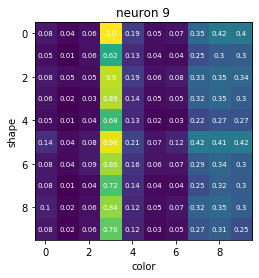

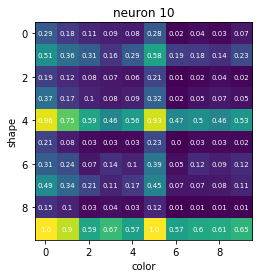

In [5]:
input_mat_list = neuron_combinations_mat_list
combination_acts_path = plot_path + "/individual_neuron_activations"
if save:
    if not os.path.exists(combination_acts_path):
        os.makedirs(combination_acts_path)
        
if num_tasks == 2:
    for branch_idx in range(len(input_mat_list)):
        if branching:
            print("BRANCH: " + str(branch_idx+1))
        plot_combination_acts(input_mat_list[branch_idx],
                              individual_neuron_plots_start_index,
                              individual_neuron_plots_end_index,
                              normalize="individual",
                              num_classes=num_classes,
                              plot_single_column=True,
                              plot_size=4,
                              dataset_name=dataset_name,
                              save=save,
                              save_path = combination_acts_path)
        
        
        
        
        

<br>

# Activation plots for attribute compositions

Sort order: task2, task1


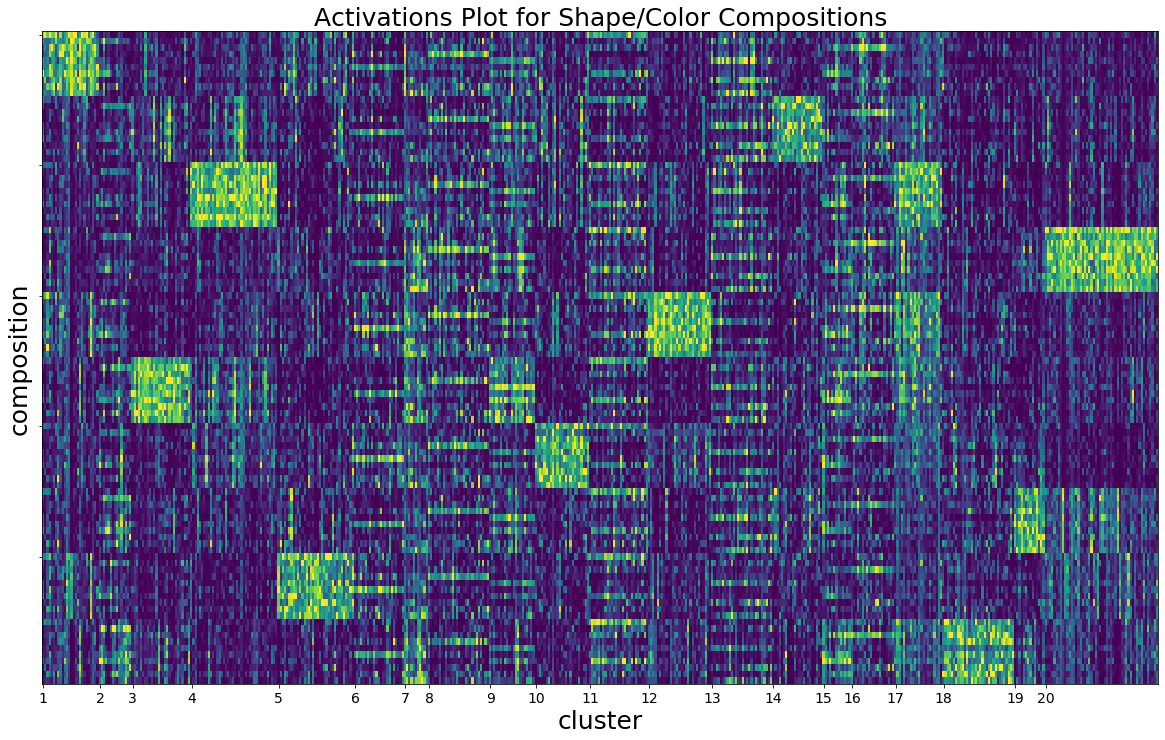

In [6]:
if sort_by_task2:
    print("Sort order: task2, task1")
else:
    print("Sort order: task1, task2")
    
    
input_mat_list = normalized_acts_mat_list
act_matrix_path = plot_path + "/full_activations"

if save:
    if not os.path.exists(act_matrix_path):
        os.makedirs(act_matrix_path)
act_matrix_path += "/" + keep_pct_string + ".pdf"

for branch_idx in range(num_branches):
    if branching:
        print("BRANCH: "+str(branch_idx+1))
    plot_act_matrix(act_matrix=input_mat_list[branch_idx], combinations_list=combinations,
                n_clusters=num_clusters,title_dataset=short_names['task2'],
               save=save,
               save_path = act_matrix_path)
    


    
    
    
    
    

<br>

# Load data for selectivity plots

- All data put into lists representing the index for each branch. If the network is late-branching, data put into size 1 list. If network is early branching, data for lower non-branching layers are duplicated for each branch.

Selectivity_dicts uses code in activation_plot_code that calculates selectivity as:
$$
\frac{S_{max}-S_{max2}}{S_{max}+s_{max2}}
$$
<br>

for compositions (where $max2$ denotes $2_{nd}$ max), and:

$$
\frac{S_{med}-S_{avg}}{S_{med}+S_{avg}}
$$
<br>

for individual tasks. $S_{med}$ is median selectivity in the group containing the selective class, while $S_{avg}$ is the average selectivity outside the selective group. 



In [10]:
# ----------- LOAD DATA FOR SELECTIVITY PLOTS --------------
if dataset_name in ["left_out_colored_mnist"]:
    keep_pct_values = [.1,.2,.3,.4,.5,.6,.7,.8,.9]
else:
    keep_pct_values = [.11,.22,.33,.44,.55,.66,.77,.88]

    
acts_dict_list = [[] for i in range(num_branches)]
if model_name == "resnet":
    layer_list = ['_layer1','_layer3','']
else:
    layer_list = ['']

for layer in layer_list:
    holdout_acts_dict_all_layers = [{} for i in range(num_branches)]
    for keep_pct in keep_pct_values:
        file_path = "../analysis/"+model_name+"/activations_data/"+dataset_name+state_dict_type+"/"
        filename = "{}_{}_keep{}{}.pkl".format(model_name, dataset_name + layer, int(100*keep_pct), state_dict_type)
        with open(file_path + filename,'rb') as f:
            temp = pickle.load(f)
            if type(temp) != type([]):
                temp = [temp for i in range(num_branches)]

            for i in range(num_branches):
                holdout_acts_dict_all_layers[i][int(100*keep_pct)] = temp[i]
                
    for i in range(num_branches):
        acts_dict_list[i].append(holdout_acts_dict_all_layers[i])
        

selectivity_dicts_list = []
for i in range(num_branches):
    selectivity_dicts = get_selectivity_dicts2(acts_dict_list[i],
                                               layer_list,keep_pct_values,
                                               combinations, num_classes)
    selectivity_dicts_list.append(selectivity_dicts)
    



<br>

# Selectivity per keep_pct (violin + errbar)



   

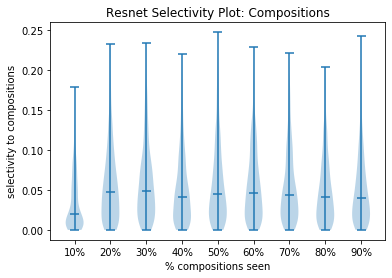

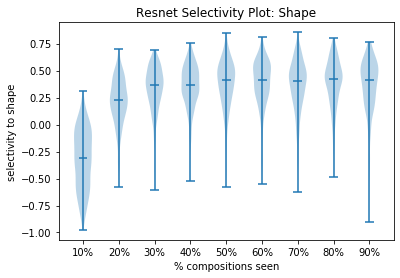

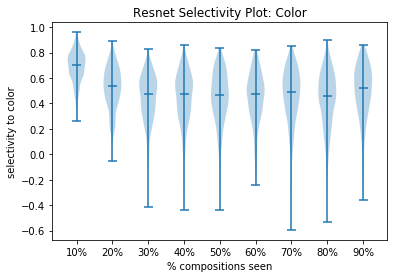

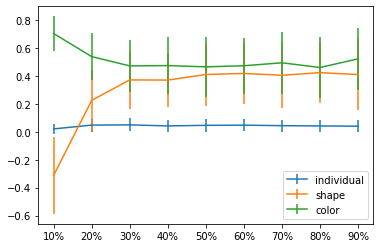

In [11]:
select_path = plot_path + "/selectivity_plots/"
if save:
    if not os.path.exists(select_path):
        os.makedirs(select_path)

import warnings
warnings.filterwarnings("ignore")
import matplotlib
from matplotlib import pyplot as plt

select1_list,select2_list,select3_list,select4_list,select5_list = [[] for j in range(5)]
LAYER = ''
#Selectivity data
for branch_idx in range(num_branches):
    select1 = selectivity_dicts_list[branch_idx][LAYER]['combos']
    select2 = selectivity_dicts_list[branch_idx][LAYER]['task1']
    select3 = selectivity_dicts_list[branch_idx][LAYER]['task2']
    
    select1_list.append(select1)
    select2_list.append(select2)
    select3_list.append(select3)
    
    if num_tasks > 2:
        select4 = selectivity_dicts_list[branch_idx][LAYER]['task3']
        select4_list.append(select4)
        
    if num_tasks == 4:
        select5 = selectivity_dicts_list[branch_idx][LAYER]['task4']
        select5_list.append(select5)
        
    
        
#Violin plot data
y1_violin_list,y2_violin_list,y3_violin_list,y4_violin_list,y5_violin_list = [[[] for i in range(num_branches)] for j in range(5)]
for branch_idx in range(num_branches):
    y1_violin_list[branch_idx] = ([select1_list[branch_idx][int(100*kpt)] for kpt in keep_pct_values])
    for kpt in keep_pct_values:
        y2_violin_list[branch_idx].append(select2[int(100*kpt)])
        y3_violin_list[branch_idx].append(select3[int(100*kpt)])
        
        if num_tasks > 2:
            y4_violin_list[branch_idx].append(select4[int(100*kpt)])
            
        if num_tasks == 4:
            y5_violin_list[branch_idx].append(select5[int(100*kpt)])
            

#errorbar data
y1_list, y2_list, y3_list, y4_list, y5_list = [[[] for i in range(num_branches)] for j in range(5)]
y1_err_list, y2_err_list, y3_err_list, y4_err_list, y5_err_list = [[[] for i in range(num_branches)] for j in range(5)]
for branch_idx in range(num_branches):
    select1 = select1_list[branch_idx]
    y1_list[branch_idx] = [np.median(select1[int(100*kpt)]) for kpt in keep_pct_values]
    y1_err_list[branch_idx] = [np.std(select1[int(100*kpt)]) for kpt in keep_pct_values]
    
    select2 = select2_list[branch_idx]
    y2_list[branch_idx] = [np.median(select2[int(100*kpt)]) for kpt in keep_pct_values]
    y2_err_list[branch_idx] = [np.std(select2[int(100*kpt)]) for kpt in keep_pct_values]
    
    select3 = select3_list[branch_idx]
    y3_list[branch_idx] = [np.median(select3[int(100*kpt)]) for kpt in keep_pct_values]
    y3_err_list[branch_idx] = [np.std(select3[int(100*kpt)]) for kpt in keep_pct_values]
    
    if num_tasks > 2:
        select4 = select4_list[branch_idx]
        y4_list[branch_idx] = [np.median(select4[int(100*kpt)]) for kpt in keep_pct_values]
        y4_err_list[branch_idx] = [np.std(select4[int(100*kpt)]) for kpt in keep_pct_values]
        
    if num_tasks == 4:
        select5 = select5_list[branch_idx]
        y5_list[branch_idx] = [np.median(select5[int(100*kpt)]) for kpt in keep_pct_values]
        y5_err_list[branch_idx] = [np.std(select5[int(100*kpt)]) for kpt in keep_pct_values]
        
    
            
xlabs = [str(int(100*kpt)) + '%' for kpt in keep_pct_values]
showmedians = show_violin_plot_median
showmeans = show_violin_plot_mean
showextrema = show_violin_plot_extrema
save=save


def plot_selectivity_violin(data, xlabs, task_name, model_name, save, select_path, keep_pct_values,showmedians,showextrema,showmeans):
    fig, ax = plt.subplots()
    plt.xlabel("% compositions seen")
    ax.set_xticks([r+1 for r in range(len(keep_pct_values))])
    ax.set_xticklabels(xlabs)
    plt.ylabel("selectivity to "+task_name)
    plt.title(make_first_upper(model_name) + " Selectivity Plot: " + make_first_upper(task_name))
    plt.violinplot(data, showmedians=showmedians,showextrema=showextrema,showmeans = showmeans)
    if save:
        plt.savefig(select_path + make_first_upper(model_name)+"_selectivity_compositions.pdf")
    plt.show()
    
def plot_selectivity_errorbar(data_list, xlabs, err_list, label_list):
    for i in range(len(data_list)):
        plt.errorbar(x=xlabs, y=data_list[i],yerr=err_list[i], label=label_list[i])

#PLOT VIOLINPLOTS
for branch_idx in range(num_branches):
    if branching:
        print("BRANCH "+str(branch_idx+1))
    plot_selectivity_violin(y1_violin_list[branch_idx], xlabs, "compositions",
                     model_name, save, select_path, keep_pct_values,
                     showmedians,showextrema,showmeans)
    
    plot_selectivity_violin(y2_violin_list[branch_idx], xlabs,  short_names['task1'],
                     model_name, save, select_path, keep_pct_values,
                     showmedians,showextrema,showmeans)
    
    plot_selectivity_violin(y3_violin_list[branch_idx], xlabs, short_names['task2'],
                     model_name, save, select_path, keep_pct_values,
                     showmedians,showextrema,showmeans)

#PLOT ERRORBAR PLOTS
for branch_idx in range(num_branches):
    if branching:
        print("BRANCH "+str(branch_idx+1))
    data_list = [d_list[branch_idx] for d_list in [y1_list,y2_list,y3_list]]
    err_list = [e_list[branch_idx] for e_list in [y1_err_list, y2_err_list, y3_err_list]]
    label_list = ['individual'] + [short_names[t] for t in ['task1','task2']]
    if num_tasks > 2:
        data_list += y4_list[branch_idx]
        err_list += y4_err_list[branch_idx]
        label_list += short_names['task3']
    if num_tasks == 4:
        data_list += y5_list[branch_idx]
        err_list += y5_err_list[branch_idx]
        label_list += short_names['task4']
    plot_selectivity_errorbar(data_list, xlabs, err_list, label_list)
    plt.legend()
    plt.show()
    





<br>

# Selectivity per layer (violin + errbar)

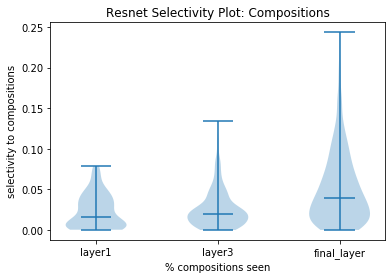

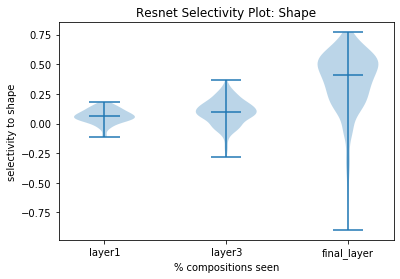

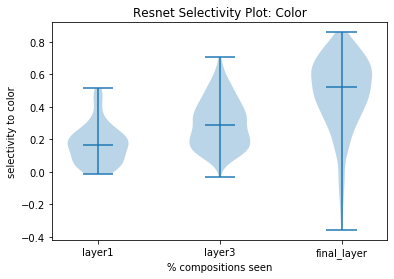

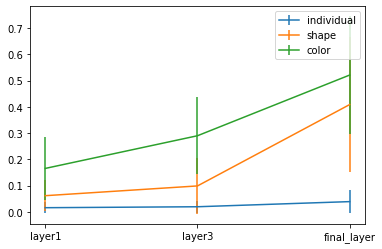

In [12]:
if model_name in ['resnet','resnet_early_branching']:
    y1_violin_list,y2_violin_list,y3_violin_list,y4_violin_list,y5_violin_list = [[[] for i in range(num_branches)] for j in range(5)]
    y1,y2,y3,y4,y5 = [[[] for i in range(num_branches)] for j in range(5)]
    y1_err,y2_err,y3_err,y4_err,y5_err = [[[] for i in range(num_branches)] for j in range(5)]
    
    xlabs = []
    keep_idx = -1
    ls = ['layer1','layer3','final_layer']
    for branch_idx in range(num_branches):
        for idx,l in enumerate(["_layer1","_layer3",""]):
            kp = int(100*keep_pct_values[keep_idx])
            selectivity_dicts2 = selectivity_dicts_list[branch_idx]
            add_y2 = selectivity_dicts2[l]['task1'][kp]
            add_y3 = selectivity_dicts2[l]['task2'][kp]
            
            if num_tasks > 2:
                add_y4 = selectivity_dicts2[l]['task3'][kp]
                y4_violin_list[branch_idx].append(add_y4)
                
            if num_tasks == 4:
                add_y5 = selectivity_dicts2[l]['task4'][kp]
                y5_violin_list[branch_idx].append(add_y5)
            
            y1_violin_list[branch_idx].append(selectivity_dicts2[l]['combos'][kp])
            y2_violin_list[branch_idx].append(add_y2)
            y3_violin_list[branch_idx].append(add_y3)
            
            y1[branch_idx].append(np.median(selectivity_dicts2[l]['combos'][kp]))
            y2[branch_idx].append(np.median(selectivity_dicts2[l]['task1'][kp]))
            y3[branch_idx].append(np.median(selectivity_dicts2[l]['task2'][kp]))
            y1_err[branch_idx].append(np.std(selectivity_dicts2[l]['combos'][kp]))
            y2_err[branch_idx].append(np.std(selectivity_dicts2[l]['task1'][kp]))
            y3_err[branch_idx].append(np.std(selectivity_dicts2[l]['task2'][kp]))
            if num_tasks > 2:
                y4[branch_idx].append(np.median(selectivity_dicts2[l]['task3'][kp]))
                y4_err[branch_idx].append(np.std(selectivity_dicts2[l]['task3'][kp]))
                
xlabs = ls        
    
#PLOT VIOLINPLOTS
for branch_idx in range(num_branches):
    if branching:
        print("BRANCH "+str(branch_idx+1))
    plot_selectivity_violin(y1_violin_list[branch_idx], xlabs, "compositions",
                     model_name, save, select_path, ls,
                     showmedians,showextrema,showmeans)
    
    plot_selectivity_violin(y2_violin_list[branch_idx], xlabs,  short_names['task1'],
                     model_name, save, select_path, ls,
                     showmedians,showextrema,showmeans)
    
    plot_selectivity_violin(y3_violin_list[branch_idx], xlabs, short_names['task2'],
                     model_name, save, select_path, ls,
                     showmedians,showextrema,showmeans)


#PLOT ERRORBAR PLOTS
for branch_idx in range(num_branches):
    if branching:
        print("BRANCH "+str(branch_idx+1))
    data_list = [d_list[branch_idx] for d_list in [y1,y2,y3]]
    err_list = [e_list[branch_idx] for e_list in [y1_err, y2_err, y3_err]]
    label_list = ['individual'] + [short_names[t] for t in ['task1','task2']]
    
    if num_tasks > 2:
        data_list += y4[branch_idx]
        err_list += y4_err[branch_idx]
        label_list += short_names['task3']
    if num_tasks == 4:
        data_list += y5[branch_idx]
        err_list += y5_err[branch_idx]
        label_list += short_names['task4']
    plot_selectivity_errorbar(data_list, xlabs, err_list, label_list)
    plt.legend()
    plt.show()


